# Clasificación Binaria con Machine Learning 

### Sebastian Calderon

## 1. Introducción y Contexto

**Descripción del Problema**:  
Una empresa de venta de coches usados quiere determinar el color óptimo para repintar vehículos en condiciones deficientes. Se han limitado a los colores blanco y negro, ya que son los más comunes en el mercado. Para tomar esta decisión, buscan desarrollar un modelo predictivo que determine si un coche originalmente era blanco o negro basándose en sus características.

**Objetivos del Análisis:**  
a. Construir de un modelo predictivo que determine si un coche debe repintarse de blanco o no, basándose en variables explicativas contenidas en una base de datos.

b. Aplicar técnicas de clasificación binaria, utilizando árboles de decisión, Random Forest y XGBoost para encontrar el mejor modelo basado en métricas de validación.

c. Análizar y comparar diferentes modelos de modelos, justificando la selección del mejor modelo en términos de rendimiento.

**Librerias Necesarias para Trabajar en Machine Learning:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.tree import export_text, plot_tree

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    log_loss,
    roc_curve,
    roc_auc_score
)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


Usaremos el siguiente codigo para evitar advertencias en nuestro libro y obtener un resultado más limpio.

In [2]:
warnings.filterwarnings('ignore')

## 2. Exploración y Preparación de Datos

**Carga y Visualización:**

In [3]:
df = pd.read_excel('datos_tarea25 (1).xlsx')
df.head()

,Price,Levy,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Wheel,Color,Airbags
0,39493,891,HYUNDAI,2016,Jeep,Yes,Diesel,2,160931 km,4,Automatic,Front,Left wheel,White,4
1,1803,761,TOYOTA,2010,Hatchback,Yes,Hybrid,1.8,258909 km,4,Automatic,Front,Left wheel,White,12
2,1098,394,TOYOTA,2014,Sedan,Yes,Hybrid,2.5,398069 km,4,Automatic,Front,Left wheel,Black,12
3,941,1053,MERCEDES-BENZ,2014,Sedan,Yes,Diesel,3.5,184467 km,6,Automatic,Rear,Left wheel,White,12
4,1019,1055,LEXUS,2013,Jeep,Yes,Hybrid,3.5,138038 km,6,Automatic,Front,Left wheel,White,12


**Descripción de los Datos:**  
Variable Objetivo: Color (variable binaria: si el coche debe pintarse de blanco o no).  
Variables Explicativas: Precio de venta, Cantidad de impuestos, Fabricante, Año de fabricación, Categoría, Interior de cuero, Tipo de combustible, Volumen del motor, Kilometraje, Cilindros, Tipo de caja de cambios, Ruedas motrices, Lugar del volante, Número de airbags.

**Valores Nulos:** 
Nos aseguramos que no existan valores nulos en el dataset, debido a que esto podria afectar su rendimiento.

In [4]:
df.isnull().sum()

Price               0
Levy                0
Manufacturer        0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Wheel               0
Color               0
Airbags             0
dtype: int64

**Analisis Exploratorio:** Para un buen manejo de los datos, vamos a revisar los valores unicos de cada columna con el fin de determinar si son valores que tienen sentido.

In [5]:
for column in df.columns:
    print(f"\nColumna: {column}")
    print(df[column].value_counts())
    print("-"*50)


Columna: Price
Price
470      101
314       92
392       83
627       72
941       72
        ... 
24123      1
10100      1
40000      1
32245      1
1176       1
Name: count, Length: 915, dtype: int64
--------------------------------------------------

Columna: Levy
Levy
-        644
1017     155
891      145
394      127
779      105
        ... 
1848       1
1604       1
2705       1
2959       1
11706      1
Name: count, Length: 203, dtype: int64
--------------------------------------------------

Columna: Manufacturer
Manufacturer
TOYOTA           1547
HYUNDAI          1234
MERCEDES-BENZ     932
LEXUS             627
Name: count, dtype: int64
--------------------------------------------------

Columna: Prod. year
Prod. year
2012    628
2014    541
2013    486
2010    424
2015    392
2016    378
2011    356
2017    320
2008    200
2018    173
2009    128
2019    101
2007     42
2006     30
2005     28
2020     19
2003     18
2001     18
2002     16
2004     13
2000     11
1998   

Del anterior analisis podemos determinar lo siguientes posibles problemas para un correcto manejo de los datos:  
1. Levy: Tiene valores con un guion (-) en lugar de un numero  
2. Mileage: Tienen la palabra "km" al final de cada valor.  
3. Engine Volume: Algunos de sus valores tienen la palabra "Turbo" al final de cada valor 

Vamos a corregir estos errores de la siguiente manera:  
Levy: reemplazando el guion por un 0 pues se refiere a los autos que no tienen un impuesto.    
Mileage: Removiendo la palabra km, debido a que se entiende que toda esta columna esta en la misma unidad.  
Engine volume: Eliminar la palabra turbo de los valores que la incluyen, sin embargo, aquí aprovecharemos esta información para crear una nueva columna llamada Engine volume turbo binaria que nos diga si el Engine es turbo o no lo es, esto puede ayudar al modelo.  


In [6]:
#Reemplazar - por 0 para la columna Levy
df['Levy'] = df['Levy'].replace('-', 0)
#Quitar la palabra km de la columna Mileage 
df['Mileage'] = df['Mileage'].str.replace(' km', '')
#Crear una columna llamada Engine_volume_turbo binaria que nos diga si el Engine es turbo o no lo es
df['Engine_volume_turbo'] = df['Engine volume'].str.contains('Turbo')
#Quitar la palabra Turbo de la columna Engine volume y dejar solo el valor numérico
df['Engine volume'] = df['Engine volume'].str.replace('Turbo', '')


**Feature Engineering**

De las variables del dataset podemos tomar información muy relevante que puede ayudar a contruir un buen modelo, por ejemplo, ya creamos una columna llamada **Engine_Volume_Turbo** a partir de otra, así tenemos una nueva variable explicativa en nuestro modelo.  

La columna Prod. Year la vamos a transformar, vamos a crear una nueva columna llamada **Age**, es decir Antiguedad, para que nos muestre los años que tiene el vehiculo, esto es mucho mas interpretable que Prod. Year, y claramente eliminaremos la columna Prod. Year pues las dos nos estarian aportando la misma información al modelo.

In [7]:
#Crear una nueva columna llamada Age a partir de la columna Prod. Year y eliminar la columna Year
df['Age'] = df['Prod. year'].apply(lambda x: 2025 - x)
df = df.drop('Prod. year', axis=1)

**Categorización de Variables** Voy a categorizar mis variables Airbags, Cylinders y Engine Volume pues no tienen muchos valores unicos y tiene mas sentido pues es una caracteristica categorica de un vehiculo

In [8]:
#Airbags
df['Airbags'] = pd.to_numeric(df['Airbags'], errors='coerce')
df['Airbags'] = df['Airbags'].apply(lambda x: '0' if x <= 0 else '1-4' if x <= 4 else '5-8' if x <= 8 else '9+')

# Cylinders
df['Cylinders'] = df['Cylinders'].apply(lambda x: x if x in [4, 6, 8] else 'Otros')

#Engine volume
df['Engine volume'] = pd.to_numeric(df['Engine volume'], errors='coerce')
df['Engine volume'] = df['Engine volume'].apply(lambda x: 
    'le_1.6L' if x <= 1.6 else     
    '1.7-2.0L' if x <= 2.0 else  
    '2.1-2.5L' if x <= 2.5 else  
    '2.6-3.5L' if x <= 3.5 else  
    '3.6-4.7L' if x <= 4.7 else  
    'gt_4.7L'
)

Vamos a ver que nuestras variables tengan el tipo de dato correcto, es muy importante que tengan el adecuado para que no exista problema con los analisis y al aplicar modelos.

In [9]:
df.dtypes

Price                   int64
Levy                   object
Manufacturer           object
Category               object
Leather interior       object
Fuel type              object
Engine volume          object
Mileage                object
Cylinders              object
Gear box type          object
Drive wheels           object
Wheel                  object
Color                  object
Airbags                object
Engine_volume_turbo      bool
Age                     int64
dtype: object

La columna Levy y Mileage  voy a tratarlas en este caso como numericas, así que vamos a asignar el tipo de dato correcto.

In [10]:
#Levy y Mileage, a numéricas
df['Levy'] = pd.to_numeric(df['Levy'], errors='coerce')
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')

Debido a que la variable Price y Levy se refieren al costo del vehiculo, voy a juntarlas en una sola variable llamada **Total_price** asi los valores 0 de la columna Levy no afectan mucho el rendimiento del modelo y así reduzco variables en el modelo.

In [11]:
# Crear una columna llamada total_price a partir de la columna Price y la columna Levy y eliminar la columna Price y Levy
df['Total_price'] = df['Price'] + df['Levy']
df = df.drop(['Price', 'Levy'], axis=1)

Finalmente voy a binarizar mi variable objetivo Color (White: True, Black: False) tambien la variable explicativa Leather Interior (Yes:True and No: False) y mi variable explicativa Wheel (Right Hand: True and Left Wheel: Flase) debido a que cada una de estas tienen solo dos opciones.

In [12]:
#Binarizar las columnas Leather interior (Yes:True, No:False) y Color (White:True, Black:False) y Wheel (Right-hand drive:True, Left wheel:False)
df['Leather interior'] = df['Leather interior'].map({'Yes': True, 'No': False})
df['Color'] = df['Color'].map({'White': True, 'Black': False})
df['Wheel'] = df['Wheel'].map({'Right-hand drive': True, 'Left wheel': False})


**Analisis Exploratorio**: Hacemos un analisis de las estadisticas mas importantes de nuestros datos.

In [13]:
#Describir las columnas numéricas
df.describe()

,Mileage,Age,Total_price
count,4.340000e+03,4340.00000,4340.000000
mean,3.960525e+05,12.15023,19996.932949
std,1.686423e+07,3.59624,23960.542214
min,0.000000e+00,5.00000,3.000000
25%,6.991800e+04,10.00000,2938.000000
50%,1.275150e+05,12.00000,14820.000000
75%,1.865420e+05,14.00000,27903.500000
max,1.111111e+09,82.00000,627220.000000


Aqui podemos identificar claramente algunas cuestiones respecto a ciertas variables:

Mileage: La media es muy alta (396,052.5 km) comparada con la mediana (127,515 km), lo que indica una fuerte asimetría positiva con valores atípicos que elevan la media, su desviación es 16,864,230 km, lo cual es demasiado., esto sugiere que pueden ser datos erroneos.  
Age: El valor maximo es de 82 años, lo cual podria sugerir un valor atipico, sin embargo se tendría que investigar, pues puede ser un vehiculo muy antiguo.
Total_Price: Aunque el precio promedio es 19,996.93, tiene una una mediana de 14,820, indicando una distribución sesgada hacia la derecha, sin embargo, puede tener sentido ya que puede tratarse de autos de precios muy elevados, autos de lujo por ejemplo.


**Outliers:** Habiendo sacado conclusiones del analisis descriptivo, vamos a ver los boxplot de estas variables para ver el comportamiento de los outliers.

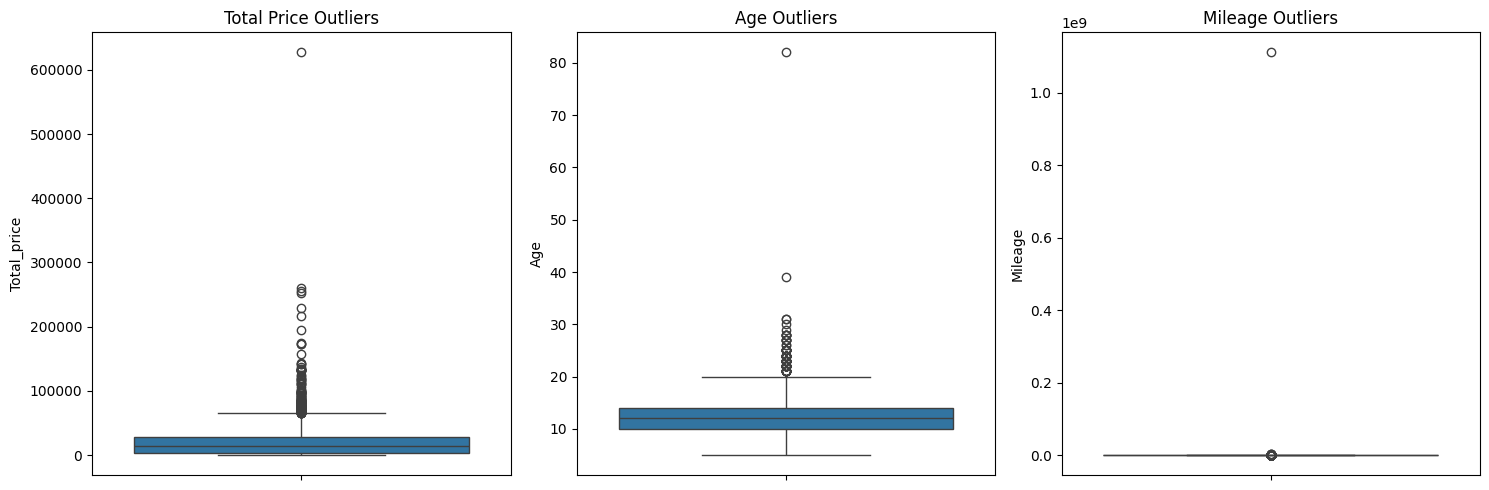

In [14]:
# Boxplot de las 3 variables para ver el comportamiento de los outliers.
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=df, y='Total_price', ax=axes[0])
axes[0].set_title('Total Price Outliers')

sns.boxplot(data=df, y='Age', ax=axes[1])
axes[1].set_title('Age Outliers')

sns.boxplot(data=df, y='Mileage', ax=axes[2])
axes[2].set_title('Mileage Outliers')

plt.tight_layout()
plt.show()

Aquí es un poco mas visible nuestros outliers, por lo que dejaremos tal como esta nuestras variables Age y Total Price, pero para la variable Mileage usaremos el Metodo IQR para eliminar los outliers.

In [15]:
# Metodo IQR para eliminar los outliers de Mileage

q1 = df['Mileage'].quantile(0.25)
q3 = df['Mileage'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"IQR method bounds: Lower = {lower_bound}, Upper = {upper_bound}")

mask = (df['Mileage'] >= lower_bound) & (df['Mileage'] <= upper_bound)
df_cleaned = df[mask].copy()

print(f"Removed {len(df) - len(df_cleaned)} outliers using IQR method")
print(f"Number of rows after: {len(df_cleaned)}")

df = df_cleaned

IQR method bounds: Lower = -105018.0, Upper = 361478.0
Removed 151 outliers using IQR method
Number of rows after: 4189


## 3. Procesamiento de Datos

Para procesar los datos vamos primero a separar las variables categoricas y numericas (sin la variable objetivo)

In [16]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object', 'bool']).drop('Color', axis=1).columns

**Aplicar one hot encoding a las variables categoricas:**

In [17]:
df = pd.get_dummies(df, columns=categorical_columns,drop_first=True)

**Selección de variables:**

**Matriz de Correlaciones:** Vamos a representar la matriz de correlaciones para ver si podemos remover alguna de las variables explicativas al momento de hacer el modelado.

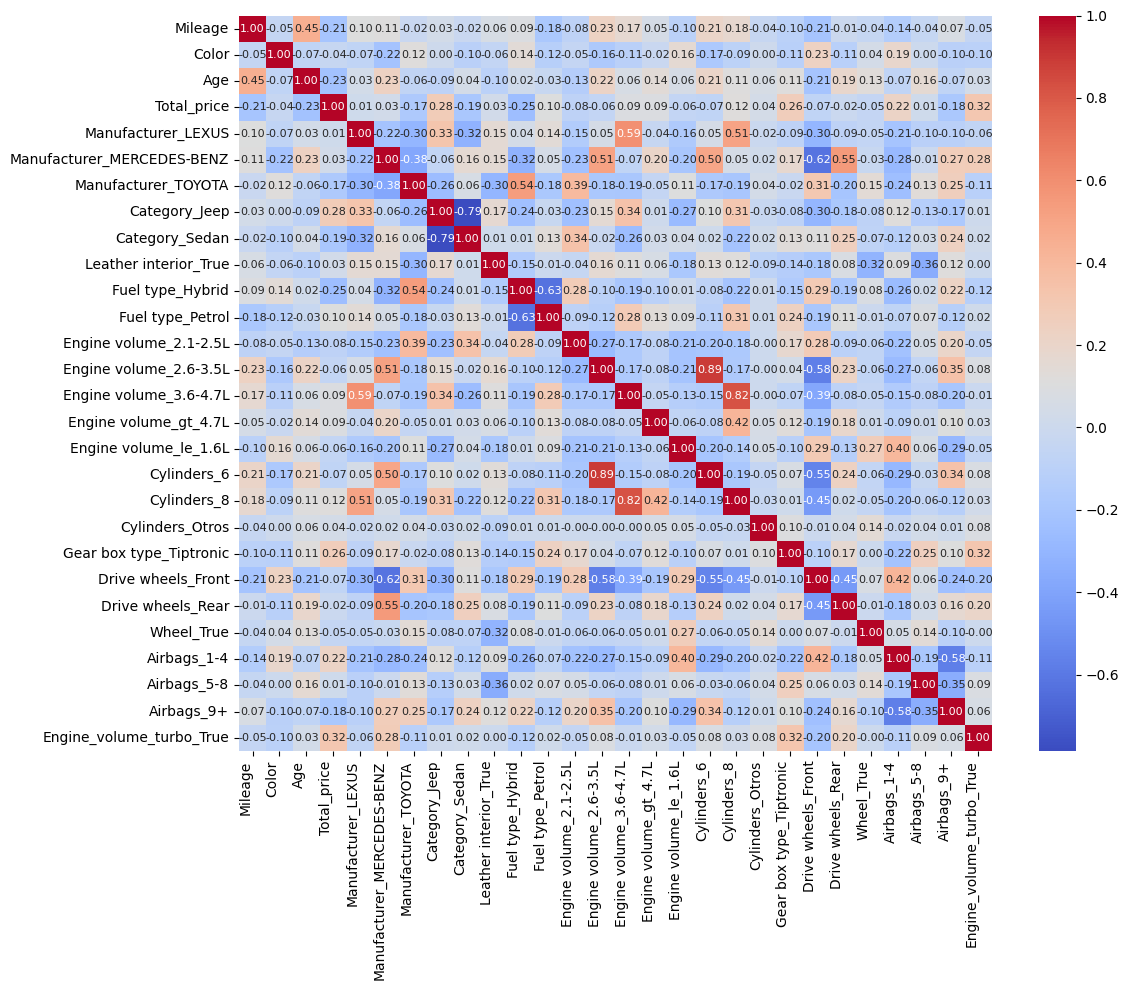

In [18]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 8})
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Aqui podemos observar que hay varias candidatas a ser eliminadas por su baja correlación con la variable objetivo Color:



**Prueba Chi-cuadrado:** Tambien haremos una prueba chi-cuadrado para ver los p valores.

In [19]:
#Prueba chi-cuadrado
for col in df.columns:
    contingency_table = pd.crosstab(df[col], df["Color"])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"Variable: {col}")
    print(f"Chi-cuadrado estadístico: {chi2_stat}")
    print(f"Valor p: {p_value}")

Variable: Mileage
Chi-cuadrado estadístico: 3304.834237210016
Valor p: 9.511016588290568e-95
Variable: Color
Chi-cuadrado estadístico: 4184.982883028861
Valor p: 0.0
Variable: Age
Chi-cuadrado estadístico: 105.17255247518975
Valor p: 3.58551200733005e-11
Variable: Total_price
Chi-cuadrado estadístico: 3511.6172883790177
Valor p: 2.4672500027800836e-81
Variable: Manufacturer_LEXUS
Chi-cuadrado estadístico: 22.034682464967915
Valor p: 2.6776800607216423e-06
Variable: Manufacturer_MERCEDES-BENZ
Chi-cuadrado estadístico: 197.6657085496854
Valor p: 6.7490268384013e-45
Variable: Manufacturer_TOYOTA
Chi-cuadrado estadístico: 58.60173489960326
Valor p: 1.9304616872217956e-14
Variable: Category_Jeep
Chi-cuadrado estadístico: 0.04518921537391654
Valor p: 0.8316564826031969
Variable: Category_Sedan
Chi-cuadrado estadístico: 42.99348869843516
Valor p: 5.492235344119909e-11
Variable: Leather interior_True
Chi-cuadrado estadístico: 14.435332324094057
Valor p: 0.00014505514452336167
Variable: Fuel ty

Analizando la matriz de correlaciones y la prueba Chi-Cuadrado optaré por eliminar las siguientes variables:   
Airbags_5-8: Con un valor p de 0.99, esta variable muestra prácticamente ninguna asociación con el color del vehículo. Es la primera candidata a eliminar.  
Cylinders_Otros: Con un valor p de 0.95, esta categoría de cilindros poco común no aporta información significativa para predecir el color.  
Category_Jeep: Con un valor p de 0.83, el hecho de que un vehículo sea tipo Jeep parece tener muy poca relación con su color.   
Engine volume_gt_4.7L: Con un valor p de 0.18, los motores de gran cilindrada tienen una asociación débil con el color.    

**Separación de Variables y División en Train y Test:**

Vamos a separar las variables explicativas X de la variable objetivo Y, teniendo en cuenta eliminar las variables explicativas que no me dan mucha información de acuerdo de a la matriz de correlaciones y la prueba Chi- cuadrado. Luego separamos el conjunto de datos en Train y Test.

In [20]:
#Separar las variables predictoras X y la variable de respuesta y
X = df.drop(['Color', 'Airbags_5-8', 'Cylinders_Otros', 'Category_Jeep', 'Engine volume_gt_4.7L'], axis=1)
y = df['Color']

#Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Revisamos ahora que las categorias de nuestra variable objetivo esten bien dividas en train y test, de lo contrario tendriamos que aplicar alguna tecnica para variables objetivos poco representadas

In [21]:
#distribución de las clases en el conjunto de prueba y entrenamiento
print(y_train.value_counts())
print(y_test.value_counts())

Color
False    1785
True     1566
Name: count, dtype: int64
Color
False    450
True     388
Name: count, dtype: int64


## 4. Modelado

### 4.1. Arbol de Decisión

A continuación vamos a realizar la mejor busqueda parametrica para el arbol de decisión, esto lo haremos mediante un Grid Search, en mi caso quiero que el **accuracy** sea mi metrica de refit, es la que mas me interesa pues me interesa saber si el modelo es capaz de determinar si el vehiculo es blanco o negro y usare 10 stplis para la validación cruzada con StratifiedKFold para evitar sobreajuste.

In [22]:
## Tuneo y evaluación predictiva del modelo para variable dependiente categórica.

params = {
    'max_depth': [16,17,18,19,20,21,22], 
    'min_samples_split': [3,4,5,6,7],  
    'criterion': ["gini", "entropy"],
    'min_samples_leaf': [2,3,4,5,6],  
    'splitter': ['random'],
    'ccp_alpha': [0.001]
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

grid_search_tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), 
                           param_grid=params, 
                           cv=StratifiedKFold(n_splits=10), scoring = scoring_metrics, refit='accuracy')
grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.001], 'criterion': ['gini', 'entropy'],
                         'max_depth': [16, 17, 18, 19, 20, 21, 22],
                         'min_samples_leaf': [2, 3, 4, 5, 6],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'splitter': ['random']},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

Ahora obtendremos el mejor modelo:

In [23]:
best_model = grid_search_tree.best_params_
print(f"Mejor modelo: {best_model}")

Mejor modelo: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 6, 'splitter': 'random'}


En muchas ocasiones el mejor modelo no es el que se obtiene mediante el best_model, depende de lo que se quieran, a veces es mejor arriesgar un poco de accuracy por robuztes y que un modelo no sobreajustado, y eso es basicamente lo que queremos en este ejercicio.

Vamos a ver los resultados del GridSearch ordenados de mayor a menor por mean accuracy, solamente los 5 primeros.

In [24]:
# Obtener los resultados del grid search tree en un DataFrame
results = pd.DataFrame(grid_search_tree.cv_results_)

# Ordenar resultados por accuracy de mayor a menor
results_sorted = results.sort_values('mean_test_accuracy', ascending=False)

# Obtener los 2 mejores modelos del grid search ordenados por accuracy
results_top2 = results_sorted.head(5)

print("\nLos 5 mejores modelos según accuracy:")
print(results_top2[['params', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_recall_macro', 'mean_test_f1_macro']])



Los 5 mejores modelos según accuracy:
                                                params  mean_test_accuracy  \
178  {'ccp_alpha': 0.001, 'criterion': 'entropy', '...            0.748428   
253  {'ccp_alpha': 0.001, 'criterion': 'entropy', '...            0.747233   
203  {'ccp_alpha': 0.001, 'criterion': 'entropy', '...            0.745744   
277  {'ccp_alpha': 0.001, 'criterion': 'entropy', '...            0.745739   
200  {'ccp_alpha': 0.001, 'criterion': 'entropy', '...            0.745442   

     mean_test_precision_macro  mean_test_recall_macro  mean_test_f1_macro  
178                   0.749887                0.746233            0.746153  
253                   0.746754                0.745338            0.745509  
203                   0.745772                0.744063            0.743958  
277                   0.745761                0.743693            0.743835  
200                   0.746744                0.742568            0.742787  


Tengo buenos modelos allí de acuerdo al accuracy, sin embargo, como tambien estoy buscando robustez, voy a encontrar dentro del top 10 de accuracy, los que tengan menor variabilidad y ordenarlos.

In [25]:
# Obtener las columnas de accuracy para cada split del cross-validation
accuracy_columns = ['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']

# Calcular la variabilidad (desviación estándar) para cada modelo
variability = results[accuracy_columns].std(axis=1)

# Calcular el accuracy promedio para cada modelo
mean_accuracy = results['mean_test_accuracy']

# Crear un DataFrame con los parámetros, variabilidad y accuracy promedio
var_df = pd.DataFrame({
    'params': results['params'],
    'variability': variability,
    'mean_accuracy': mean_accuracy
})

# Obtener el top 10 de modelos por accuracy
top_10_accuracy = var_df.nlargest(10, 'mean_accuracy')

# De esos 10, obtener los 5 con menor variabilidad
top_2_robust = top_10_accuracy.nsmallest(5, 'variability')

print("Top 2 modelos con menor variabilidad dentro del top 10 por accuracy:")
for i, row in top_2_robust.iterrows():
    print(f"\nModelo {i}:")
    print(f"Parámetros: {row['params']}")
    print(f"Accuracy promedio: {row['mean_accuracy']:.10f}")
    print(f"Variabilidad: {row['variability']:.10f}")

Top 2 modelos con menor variabilidad dentro del top 10 por accuracy:

Modelo 253:
Parámetros: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 6, 'splitter': 'random'}
Accuracy promedio: 0.7472334755
Variabilidad: 0.0166279111

Modelo 203:
Parámetros: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 6, 'splitter': 'random'}
Accuracy promedio: 0.7457436034
Variabilidad: 0.0169935947

Modelo 200:
Parámetros: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 3, 'splitter': 'random'}
Accuracy promedio: 0.7454415423
Variabilidad: 0.0174612388

Modelo 201:
Parámetros: {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 4, 'splitter': 'random'}
Accuracy promedio: 0.7454415423
Variabilidad: 0.0174612388

Modelo 304:
Parámetros: {'ccp_alpha': 0.001, 'criterion': 'entropy', '

Ahora si puedo tomar algunos de estos modelos como candidatos para compararlo y ver su robuztes para elegir uno, los 3 primeros los tomaré del top de accuracy y los dos ultimos del top de menor variabilidad.

In [26]:
ac_1_tree = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[178]
ac_2_tree = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[253] 
ac_3_tree = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[203] 
ac_4_tree = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[200]
ac_5_tree = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[201]

Ahora vamos a graficarlos para elegir nuestro modelo

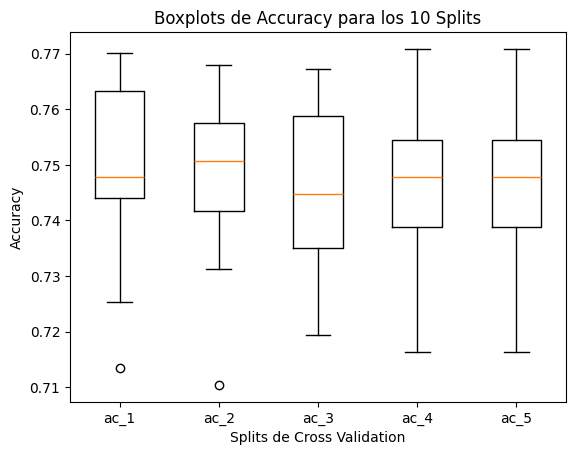

In [27]:
# Crear un boxplot para los cinco modelos
plt.boxplot([ac_1_tree.values,ac_2_tree.values,ac_3_tree.values,ac_4_tree.values,ac_5_tree.values], labels = ['ac_1','ac_2','ac_3','ac_4','ac_5'])
plt.title('Boxplots de Accuracy para los 10 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

**Mejor Modelo:** Claramente se puede ver que el modelo ac_2 es la mejor opción por lo siguiente:  
Buen balance entre rendimiento y robustez: Tiene un accuracy casi tan alto como ac_1 pero con menor variabilidad entre splits.  
Estabilidad: La caja (que representa el 50% central de los datos) es más compacta, lo que indica un comportamiento más consistente en diferentes subconjuntos de datos.  
Robustez: A pesar de tener un valor atípico, la mayoría de sus resultados están en un rango más estrecho, lo que sugiere mayor estabilidad frente a diferentes divisiones de los datos.

Así que obtenemos los parametros del modelo ac_2 que tiene el indice 253.

In [28]:
results.iloc[253].params

{'ccp_alpha': 0.001,
 'criterion': 'entropy',
 'max_depth': 19,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'splitter': 'random'}

Y creamos, entrenamos y evaluamos nuestro arbol de decisión con estos parametros.

In [29]:
# Crear y entrenar el modelo de arbol de decisión con los mejores parámetros encontrados
best_model_tree = DecisionTreeClassifier(
    max_depth=19, 
    min_samples_split=6,
    criterion='entropy',
    min_samples_leaf=2,
    random_state=42,
    splitter='random',
    ccp_alpha=0.001
)
best_model_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=19,
                       min_samples_leaf=2, min_samples_split=6, random_state=42,
                       splitter='random')

In [30]:
#Evaluar el modelo en conjunto de entrenamiento y de prueba
y_train_pred = best_model_tree.predict(X_train)
y_test_pred = best_model_tree.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')

Se tiene un accuracy para train de: 0.8179647866308565
Se tiene un accuracy para test de: 0.7768496420047732


Nos da un buen accuracy en test 0.77, sin embargo, puede que este un poco sobreajustado debido a que en train obtenemos un 0.81.

Ahora vamos a ver la importancia de las variables en el modelo de arbol de decisión.

In [31]:
print(pd.DataFrame({'nombre': best_model_tree.feature_names_in_, 'importancia': best_model_tree.feature_importances_}))

                        nombre  importancia
0                      Mileage     0.221212
1                          Age     0.116713
2                  Total_price     0.178212
3           Manufacturer_LEXUS     0.025801
4   Manufacturer_MERCEDES-BENZ     0.018772
5          Manufacturer_TOYOTA     0.042536
6               Category_Sedan     0.041530
7        Leather interior_True     0.013950
8             Fuel type_Hybrid     0.003126
9             Fuel type_Petrol     0.046053
10      Engine volume_2.1-2.5L     0.033549
11      Engine volume_2.6-3.5L     0.006035
12      Engine volume_3.6-4.7L     0.001362
13       Engine volume_le_1.6L     0.021271
14                 Cylinders_6     0.026877
15                 Cylinders_8     0.011720
16     Gear box type_Tiptronic     0.029512
17          Drive wheels_Front     0.083808
18           Drive wheels_Rear     0.018075
19                  Wheel_True     0.004970
20                 Airbags_1-4     0.018218
21                  Airbags_9+  

Aqui vemos que todas las variables aportan algo a la predicción del modelo, podriamos considerar eliminar algunas con bajo nivel como Engine volume_3.6-4.7L y volver a aplicar el modelo.

Ahora vamos a graficar la importancia de estas variables:

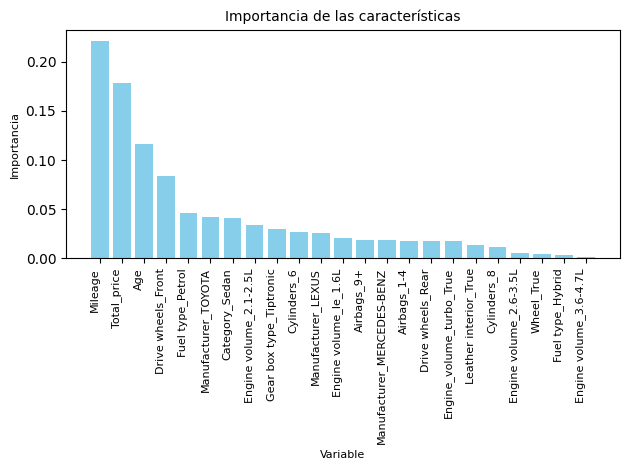

In [32]:
df_importancia = pd.DataFrame({'Variable': best_model_tree.feature_names_in_, 'Importancia': best_model_tree.feature_importances_}).sort_values(by='Importancia', ascending=False)

plt.bar(df_importancia['Variable'], df_importancia['Importancia'], color='skyblue')
plt.xlabel('Variable', fontsize=8)
plt.ylabel('Importancia', fontsize=8)
plt.title('Importancia de las características', fontsize=10)
plt.xticks(rotation=90, ha='right', fontsize=8)  # Rotar los nombres en el eje x y reducir tamaño
plt.tight_layout()

plt.show()

Aqui vemos que tenemos variables predictores muy fuertes como Mileage, Total_Price, Age y Drive Wheels_Front, si se busca un modelo sencillo, se podria crear un modelo solo con estas variables. sin embargo tengo mas que me estan aportando información y como use el parametro de poda ccp_alpha=0.001 la importancia de algunas variables sufrio cambios en este modelo.

Vamos a ver las reglas del modelo en formato texto:

In [33]:
tree_rules = export_text(best_model_tree, feature_names=list(X.columns),show_weights=True)
print(tree_rules)

|--- Drive wheels_Front <= 0.73
|   |--- Manufacturer_TOYOTA <= 0.94
|   |   |--- Fuel type_Petrol <= 0.36
|   |   |   |--- Category_Sedan <= 0.08
|   |   |   |   |--- Age <= 13.29
|   |   |   |   |   |--- Cylinders_8 <= 0.89
|   |   |   |   |   |   |--- Engine_volume_turbo_True <= 0.86
|   |   |   |   |   |   |   |--- Mileage <= 73338.05
|   |   |   |   |   |   |   |   |--- Gear box type_Tiptronic <= 0.53
|   |   |   |   |   |   |   |   |   |--- weights: [0.00, 12.00] class: True
|   |   |   |   |   |   |   |   |--- Gear box type_Tiptronic >  0.53
|   |   |   |   |   |   |   |   |   |--- weights: [3.00, 3.00] class: False
|   |   |   |   |   |   |   |--- Mileage >  73338.05
|   |   |   |   |   |   |   |   |--- Manufacturer_LEXUS <= 0.75
|   |   |   |   |   |   |   |   |   |--- Mileage <= 228741.13
|   |   |   |   |   |   |   |   |   |   |--- weights: [1.00, 7.00] class: True
|   |   |   |   |   |   |   |   |   |--- Mileage >  228741.13
|   |   |   |   |   |   |   |   |   |   |--- Mile

Y ahora vamos a graficar el arbol, en este caso al ser tan grande, voy a filtrar para ver los 3 primeros niveles:

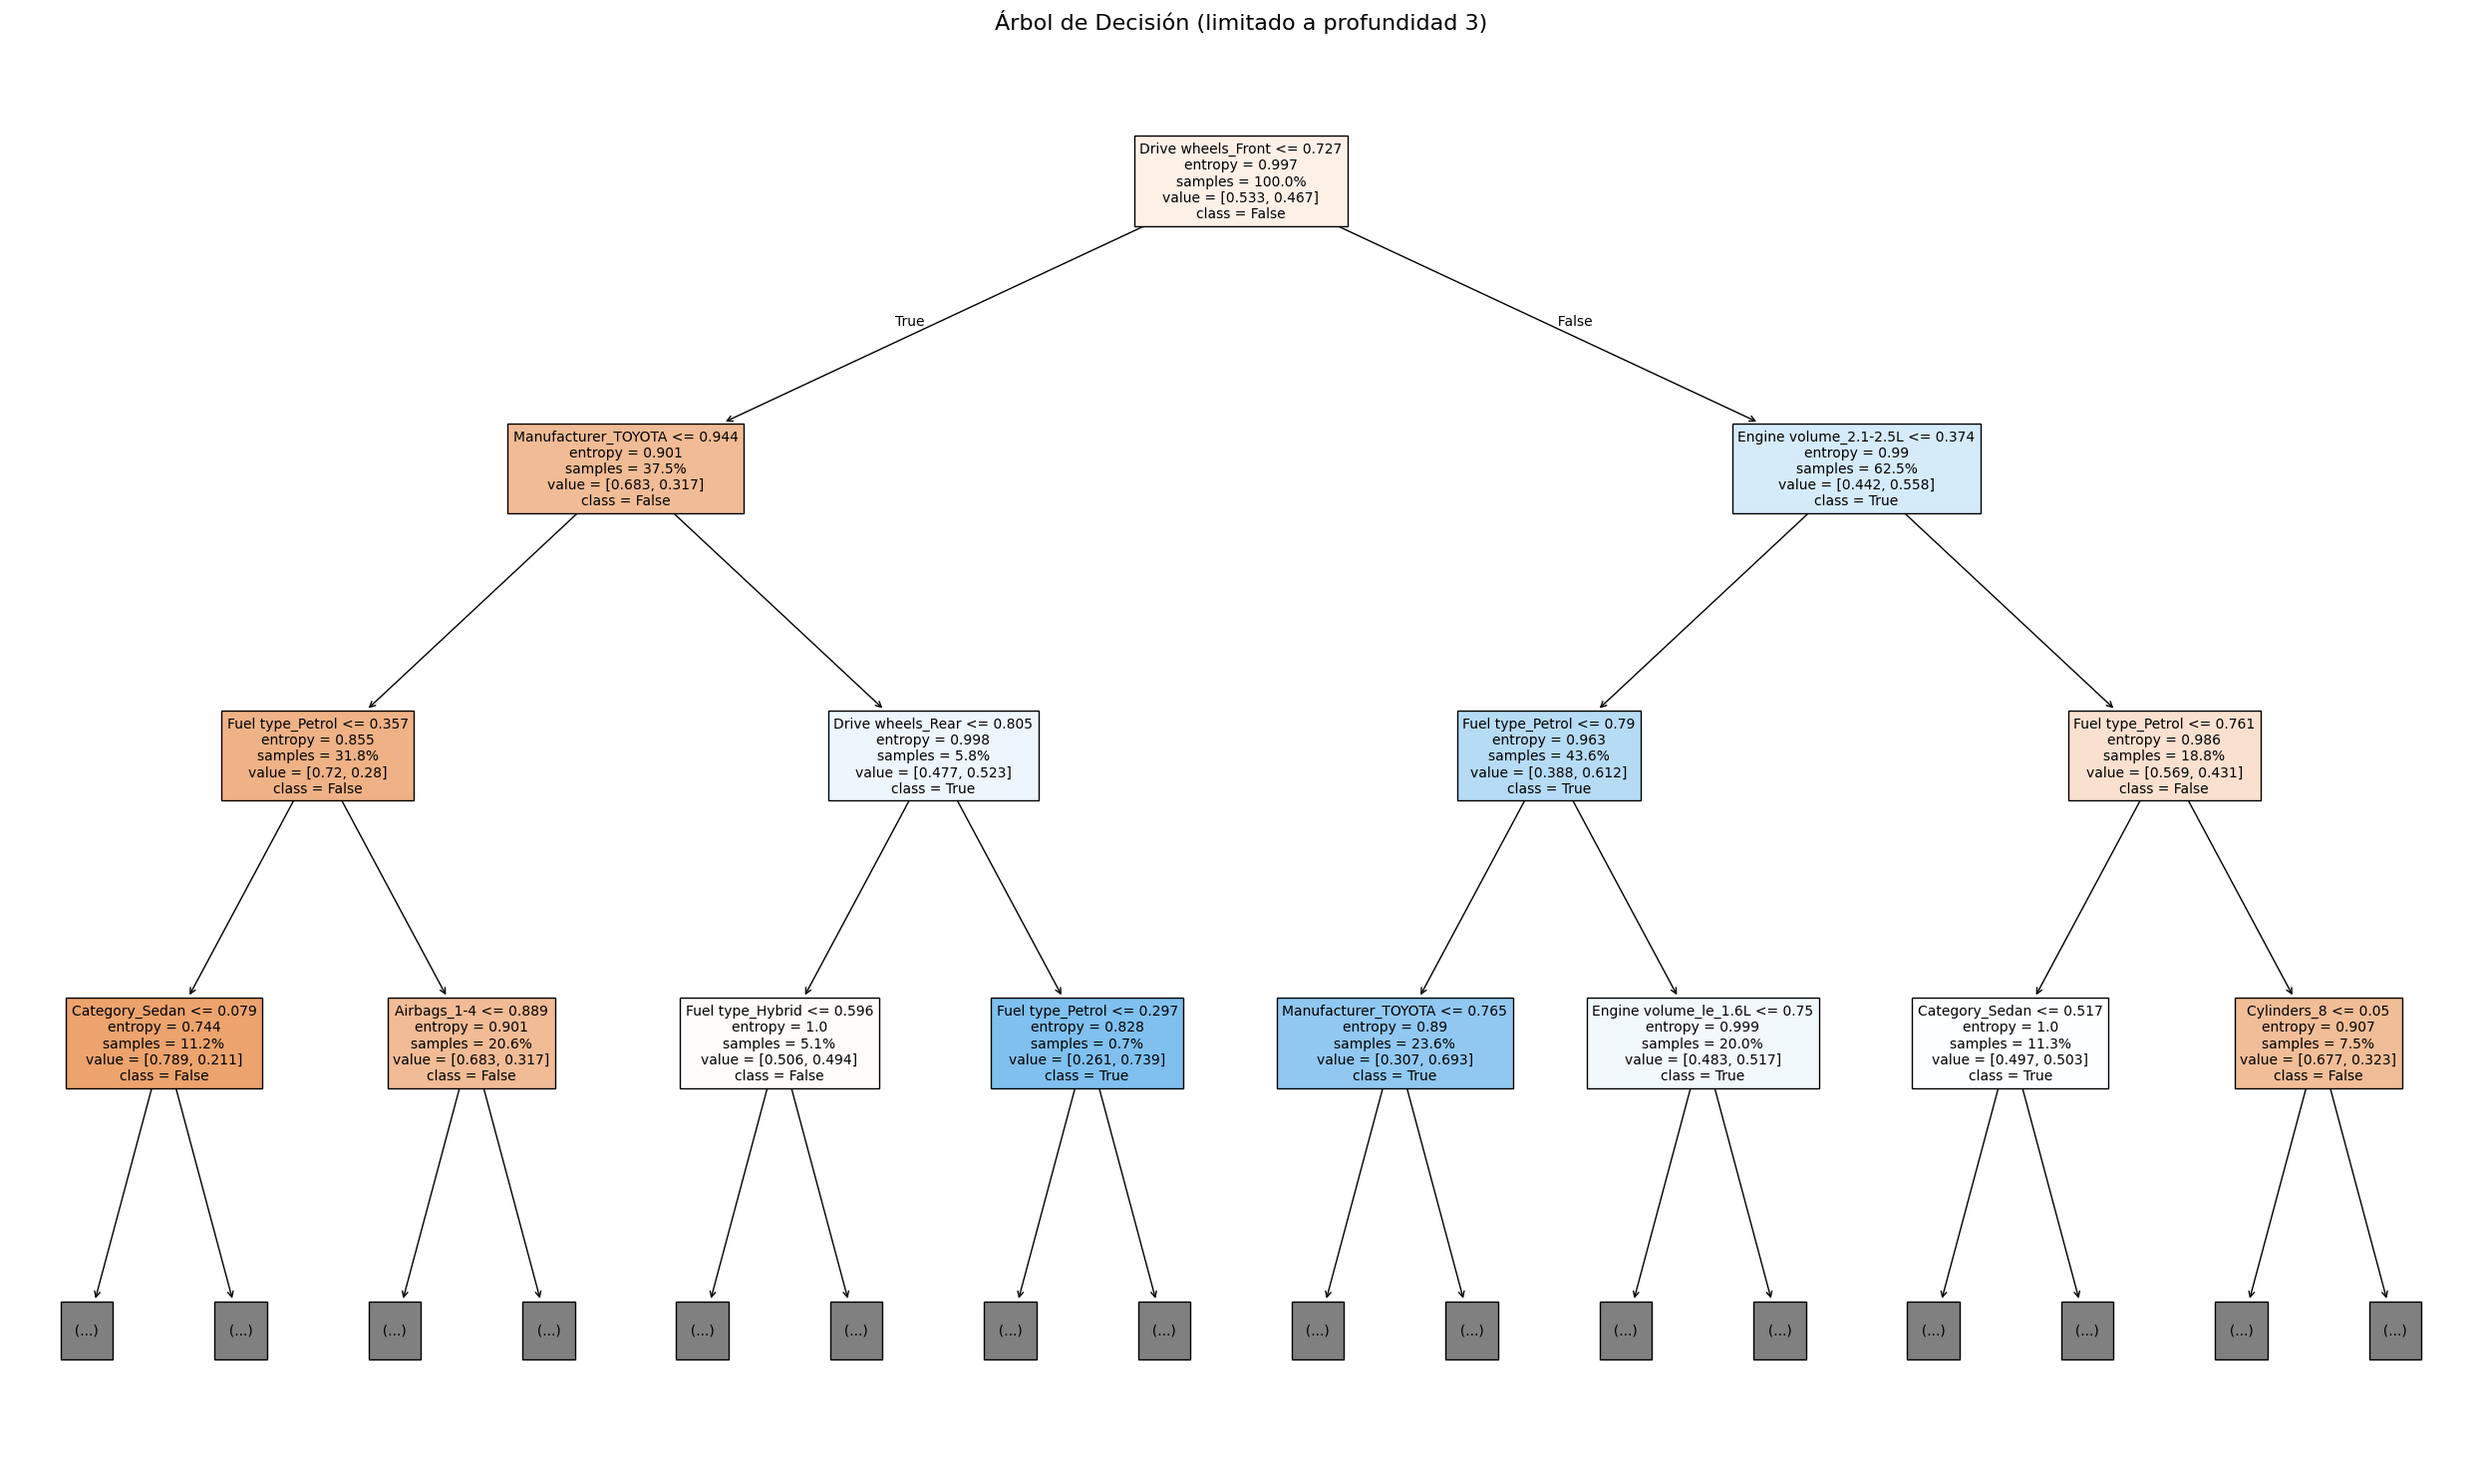

In [34]:
plt.figure(figsize=(25, 15))  
plot_tree(best_model_tree, 
          feature_names=X.columns.tolist(), 
          class_names=['False', 'True'], 
          filled=True,
          proportion=True,
          max_depth=3, 
          fontsize=10)  
plt.title('Árbol de Decisión (limitado a profundidad 3)', fontsize=16)
plt.tight_layout()
plt.show()

### 4.2. RANDOM FOREST

Ahora vamos a aplicar un modelo de Random Forest, para ello vamos a buscar nuevamente la mejor combinación parametrica con un Grid Search, en este caso vamso a intentar tener el max_depth bajo para evitar sobreajuste, el bootstrap tambien estará activo para que el modelo generalice mejor, y nuevamente vamos a usar el ccp_alpha para una poda que nos ayude a evitar sobreajuste. Tambien, voy a usar el gini como criterio pues la entropia puede hacer que el modelo sea complejo sin traer mucho beneficio.

In [35]:
params = {
    'n_estimators' : [192,193,194],  
    'max_depth': [13,14,15],  
    'bootstrap': [True], 
    'min_samples_leaf' : [3, 4],  
    'min_samples_split': [4, 5],  
    'criterion': ["gini"], 
    'class_weight': ['balanced'],
    'ccp_alpha':[0.001]
}

scoring_metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

# cv = crossvalidation
grid_search_RF = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=params, 
                           cv=StratifiedKFold(n_splits=10), scoring = scoring_metrics, refit='accuracy')
grid_search_RF.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [True], 'ccp_alpha': [0.001],
                         'class_weight': ['balanced'], 'criterion': ['gini'],
                         'max_depth': [13, 14, 15], 'min_samples_leaf': [3, 4],
                         'min_samples_split': [4, 5],
                         'n_estimators': [192, 193, 194]},
             refit='accuracy',
             scoring=['accuracy', 'precision_macro', 'recall_macro',
                      'f1_macro'])

Ahora vamos a ver el resultado del Grid Search en una tabla para poder identificar la lista de las mejores combinaciones parametricas.

In [36]:
results = pd.DataFrame(grid_search_RF.cv_results_)
results_sorted = results.sort_values('mean_test_accuracy', ascending=False)
print(results_sorted[['params', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_recall_macro', 'mean_test_f1_macro']])


                                               params  mean_test_accuracy  \
24  {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.755896   
27  {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.755896   
26  {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.755300   
29  {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.755300   
25  {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.755000   
28  {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.755000   
15  {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.754402   
12  {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.754402   
3   {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.753804   
0   {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.753804   
8   {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.753507   
9   {'bootstrap': True, 'ccp_alpha': 0.001, 'class...            0.753507   

Voy a repetir el proceso que hicimos en el arbol de decisión para obtener los 5 modeloes con menor variabilidad en los splits del cross validation para seleccionar algunos de alli en el paso de la elección del mejor modelo.

In [37]:
# Obtener las columnas de accuracy para cada split del cross-validation
accuracy_columns = ['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']

# Calcular la variabilidad (desviación estándar) para cada modelo
variability = results[accuracy_columns].std(axis=1)

# Calcular el accuracy promedio para cada modelo
mean_accuracy = results['mean_test_accuracy']

# Crear un DataFrame con los parámetros, variabilidad y accuracy promedio
var_df = pd.DataFrame({
    'params': results['params'],
    'variability': variability,
    'mean_accuracy': mean_accuracy
})

top_10_accuracy = var_df.nlargest(10, 'mean_accuracy')
top_5_robust = top_10_accuracy.nsmallest(5, 'variability')

print("Top 5 modelos con menor variabilidad dentro del top 10 por accuracy:")
for i, row in top_5_robust.iterrows():
    print(f"\nModelo {i}:")
    print(f"Parámetros: {row['params']}")
    print(f"Accuracy promedio: {row['mean_accuracy']:.10f}")
    print(f"Variabilidad: {row['variability']:.10f}")

Top 5 modelos con menor variabilidad dentro del top 10 por accuracy:

Modelo 24:
Parámetros: {'bootstrap': True, 'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 192}
Accuracy promedio: 0.7558955224
Variabilidad: 0.0187359842

Modelo 27:
Parámetros: {'bootstrap': True, 'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 192}
Accuracy promedio: 0.7558955224
Variabilidad: 0.0187359842

Modelo 26:
Parámetros: {'bootstrap': True, 'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 194}
Accuracy promedio: 0.7553002843
Variabilidad: 0.0195494242

Modelo 29:
Parámetros: {'bootstrap': True, 'ccp_alpha': 0.001, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 3, 'min_sa

Procedemos a seleccionar los indices de los modelos candidatos de entre la lista de resultados ordenados por accuracy y la lista de los modelos con menor variabilidad.

In [38]:
ac_1_RF = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[24]
ac_2_RF = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[26] 
ac_3_RF = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[25]
ac_4_RF = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[29]
ac_5_RF = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[15]

Vamos a crear un boxplot que permita ver estos 5 modelos candidatos para ver como se comportan y elegir el ganador.

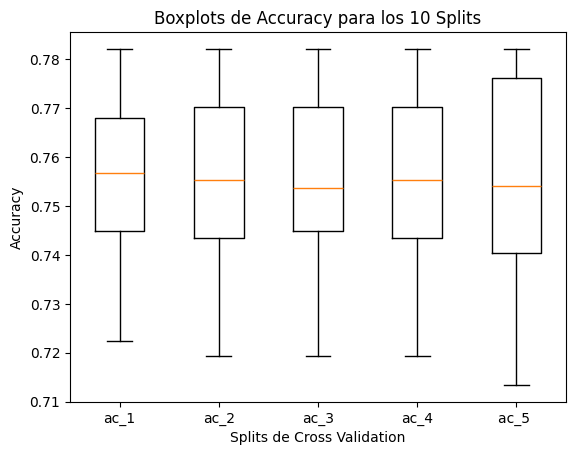

In [39]:
# Boxplot para ver la robustez de los modelos
plt.boxplot([ac_1_RF.values,ac_2_RF.values,ac_3_RF.values,ac_4_RF.values,ac_5_RF.values], labels = ['ac_1','ac_2','ac_3','ac_4','ac_5 '])
plt.title('Boxplots de Accuracy para los 10 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

**Mejor Modelo:** Tras analizar los boxplots de accuracy, seleccioné el modelo ac_1 debido a:  

Su mediana es comparable a los demás modelos mientras mantiene mayor consistencia  
Presenta el valor mínimo de accuracy más alto entre todos los modelos, reduciendo el riesgo de predicciones deficientes  
Su rango intercuartílico (tamaño de la caja) es el más compacto, indicando mayor robustez y estabilidad en las predicciones  
Esta combinación de estabilidad y límite inferior favorable lo convierte en la opción más confiable para implementación en producción.

Vamos a ver los parametros del modelo ac_1

In [40]:
results.iloc[24].params

{'bootstrap': True,
 'ccp_alpha': 0.001,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 192}

Ahora creamos, entrenamos y evaluamos nuestro Random Forest con estos parametros.

In [41]:
#Crear y entrenar el modelo
best_model_RF = RandomForestClassifier(
    n_estimators=192,
    max_depth=15,
    bootstrap=True,
    min_samples_leaf=3,
    min_samples_split=4,
    criterion='gini',
    class_weight='balanced',
    random_state=42,
    ccp_alpha=0.001,
)
best_model_RF.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.001, class_weight='balanced', max_depth=15,
                       min_samples_leaf=3, min_samples_split=4,
                       n_estimators=192, random_state=42)

In [42]:
# Evaluamos el modelo en conjunto de entrenamiento y prueba

y_train_pred = best_model_RF.predict(X_train)
y_test_pred = best_model_RF.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')

Se tiene un accuracy para train de: 0.8066248880931065
Se tiene un accuracy para test de: 0.7684964200477327


Los resultados muestran un buen accuracy en el test: 0.76, sin embargo, en train obtuvimos 0.80, lo que nos indica un poco de sobreajuste, aunque no es nada preocupantr.

### 4.1. Modelo XGBOOST

Como último modelo, aplicaremos XGBoost optimizando sus hiperparámetros mediante Random Search para reducir tiempo de cómputo. Mantendremos el learning rate ('eta') en 0.01 para evitar sobreajuste, mientras exploramos una amplia combinación de valores para los demás parámetros.

In [43]:
params = {
    'n_estimators': [290,291,292,293,294],
    'eta': [0.01],  
    'max_depth': [6,7,8, 9, 10],
    'gamma': [0.1, 0.3, 0.5],
    'subsample': [0.5,0.6,0.8],
    'reg_alpha': [3,4,5,6],
    'reg_lambda': [1,2,3,4]
}

random_search_XGB = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=params,
    n_iter=20,
    cv=StratifiedKFold(n_splits=10),
    scoring=scoring_metrics,
    refit='accuracy',
    n_jobs=-1,
    random_state=42
)

random_search_XGB.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impo...
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'eta': [0.01], 'gamma': [0.1, 0.3, 0.5],
                                        'max_depth': [6, 7, 8, 9, 10],
                                        'n_estimators': [290, 291, 292, 293,
                                                         294],
                                        'reg_alpha': [3, 4, 5, 6],
                                        'reg_lambda': [1, 2, 3, 4],
                                        'subsample': [0.5, 0.6, 0.8]},
                   random_state=42, refit='accuracy',
                   scoring=['accuracy', 'precision_macro', 'recall_macro',
                            'f1_macro'])

Ahora analizaremos los resultados del Random Search mediante una tabla ordenada por accuracy medio, lo que nos permitirá identificar las mejores combinaciones paramétricas.

In [44]:
#Ver resultados del grid search y ordenar por accuracy
results = pd.DataFrame(random_search_XGB.cv_results_)
results_sorted = results.sort_values('mean_test_accuracy', ascending=False)
print(results_sorted[['params', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_recall_macro', 'mean_test_f1_macro']])

                                               params  mean_test_accuracy  \
18  {'subsample': 0.8, 'reg_lambda': 2, 'reg_alpha...            0.750226   
19  {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha...            0.747838   
4   {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha...            0.746642   
6   {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha...            0.745150   
13  {'subsample': 0.8, 'reg_lambda': 4, 'reg_alpha...            0.744254   
1   {'subsample': 0.5, 'reg_lambda': 2, 'reg_alpha...            0.740974   
15  {'subsample': 0.5, 'reg_lambda': 2, 'reg_alpha...            0.740377   
2   {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha...            0.738287   
0   {'subsample': 0.5, 'reg_lambda': 3, 'reg_alpha...            0.737990   
8   {'subsample': 0.5, 'reg_lambda': 4, 'reg_alpha...            0.737690   
7   {'subsample': 0.5, 'reg_lambda': 3, 'reg_alpha...            0.735006   
9   {'subsample': 0.6, 'reg_lambda': 4, 'reg_alpha...            0.732022   

Seleccionaremos los 5 modelos con menor variabilidad entre los splits del cross validation para considerarlos en la etapa final de elección del mejor modelo.

In [45]:
# Obtener las columnas de accuracy para cada split del cross-validation
accuracy_columns = ['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']

# Calcular la variabilidad (desviación estándar) para cada modelo
variability = results[accuracy_columns].std(axis=1)

# Calcular el accuracy promedio para cada modelo
mean_accuracy = results['mean_test_accuracy']

# Crear un DataFrame con los parámetros, variabilidad y accuracy promedio
var_df = pd.DataFrame({
    'params': results['params'],
    'variability': variability,
    'mean_accuracy': mean_accuracy
})

top_10_accuracy = var_df.nlargest(10, 'mean_accuracy')
top_5_robust = top_10_accuracy.nsmallest(5, 'variability')

print("Top 5 modelos con menor variabilidad dentro del top 10 por accuracy:")
for i, row in top_5_robust.iterrows():
    print(f"\nModelo {i}:")
    print(f"Parámetros: {row['params']}")
    print(f"Accuracy promedio: {row['mean_accuracy']:.10f}")
    print(f"Variabilidad: {row['variability']:.10f}")

Top 5 modelos con menor variabilidad dentro del top 10 por accuracy:

Modelo 0:
Parámetros: {'subsample': 0.5, 'reg_lambda': 3, 'reg_alpha': 3, 'n_estimators': 291, 'max_depth': 9, 'gamma': 0.5, 'eta': 0.01}
Accuracy promedio: 0.7379895167
Variabilidad: 0.0171487401

Modelo 8:
Parámetros: {'subsample': 0.5, 'reg_lambda': 4, 'reg_alpha': 3, 'n_estimators': 290, 'max_depth': 10, 'gamma': 0.3, 'eta': 0.01}
Accuracy promedio: 0.7376901208
Variabilidad: 0.0178248189

Modelo 15:
Parámetros: {'subsample': 0.5, 'reg_lambda': 2, 'reg_alpha': 3, 'n_estimators': 291, 'max_depth': 9, 'gamma': 0.5, 'eta': 0.01}
Accuracy promedio: 0.7403766880
Variabilidad: 0.0181721599

Modelo 1:
Parámetros: {'subsample': 0.5, 'reg_lambda': 2, 'reg_alpha': 3, 'n_estimators': 293, 'max_depth': 10, 'gamma': 0.5, 'eta': 0.01}
Accuracy promedio: 0.7409737029
Variabilidad: 0.0185361454

Modelo 2:
Parámetros: {'subsample': 0.8, 'reg_lambda': 3, 'reg_alpha': 6, 'n_estimators': 292, 'max_depth': 9, 'gamma': 0.1, 'eta': 0.0

Y elegimos los mejores modelos candidatos considerando los 3 de mayor accuracy y los 2 de menor variabilidad.

In [46]:
ac_1_XGB = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[18]
ac_2_XGB = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[19] 
ac_3_XGB = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[0] 
ac_4_XGB = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[1]
ac_5_XGB = results[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
                    'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy', 'split8_test_accuracy','split9_test_accuracy']].iloc[15]


Creamos un boxplot para visualizar la robustez del modelo durante el cross validation.

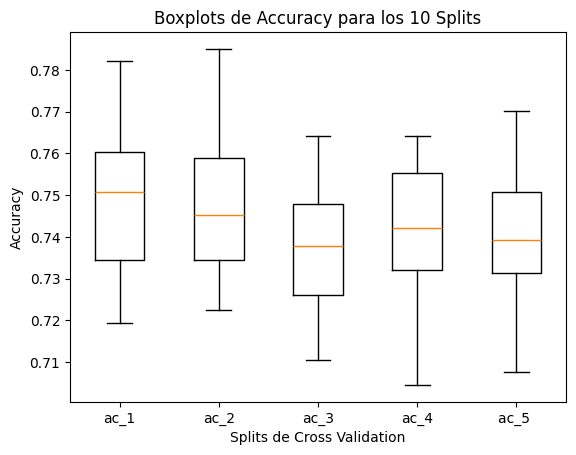

In [47]:
plt.boxplot([ac_1_XGB.values,ac_2_XGB.values,ac_3_XGB.values,ac_4_XGB.values,ac_5_XGB.values], labels = ['ac_1','ac_2','ac_3','ac_4','ac_5 '])
plt.title('Boxplots de Accuracy para los 10 Splits')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

**Mejor Modelo:** Elijo el modelo ac_2 por tener la caja más compacta (mostrando robustez), el accuracy máximo más alto de todos, y aunque su valor mínimo es el menor entre todos los modelos, su media es la segunda más alta.

Vamos a ver los parametros del modelo:

In [48]:
results.iloc[19].params

{'subsample': 0.8,
 'reg_lambda': 3,
 'reg_alpha': 4,
 'n_estimators': 290,
 'max_depth': 10,
 'gamma': 0.5,
 'eta': 0.01}

Vamos ahora a crear, entrenar y evaluar del XGBoost con estos parametros

In [49]:
#Crear y entrenar el modelo de xgboost
best_model_XGB = XGBClassifier(
    n_estimators=290,
    eta=0.01,
    gamma=0.5,
    max_depth=10,
    reg_alpha=4,
    subsample=0.8,
    reg_lambda=3,
)

best_model_XGB.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=0.5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=290,
              n_jobs=None, num_parallel_tree=None, ...)

In [50]:
# Predicciones en conjunto de entrenamiento y prueba

y_train_pred = best_model_XGB.predict(X_train)
y_test_pred = best_model_XGB.predict(X_test)
print(f'Se tiene un accuracy para train de: {accuracy_score(y_train,y_train_pred)}')
print(f'Se tiene un accuracy para test de: {accuracy_score(y_test,y_test_pred)}')

Se tiene un accuracy para train de: 0.8039391226499553
Se tiene un accuracy para test de: 0.7732696897374701


El accuracy del modelo es bueno, 0.77 en el test, y para el train 0.80, nos sugiere que hay solo un poco de sobreajuste, sin embargo, es un buen resultado.

## 5. Elección del Modelo

### Metricas

Vamos a obtener las matricas de Acuracy, Precision, Recall y F1 para los ganadores de los 3 modelos:

In [51]:
modelos = [best_model_tree, best_model_RF, best_model_XGB]
nombres = ['Decision Tree', 'Random Forest', 'XGBoost']

# Evaluar métricas detalladas
for modelo, nombre in zip(modelos, nombres):
    y_pred = modelo.predict(X_test)
    
    # Calcular las métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro') 
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"\nModelo: {nombre}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")


Modelo: Decision Tree
Accuracy:  0.7768
Precision: 0.7762
Recall:    0.7741
F1-Score:  0.7748

Modelo: Random Forest
Accuracy:  0.7685
Precision: 0.7673
Recall:    0.7667
F1-Score:  0.7670

Modelo: XGBoost
Accuracy:  0.7733
Precision: 0.7730
Recall:    0.7701
F1-Score:  0.7710


Basado en accuracy que es mi metrica debido a que me interesa saber que tanto puedo predecir si un vehiculo pertenece a una clase o la otra para saber si pintarlo o no, el mejor modelo es Decision Tree con un valor de 0.7768, seguido por XGBoost (0.7733) y finalmente Random Forest (0.7685)

### Robustez

Generemos un Boxplot para ver que podemos inferir respecto a la robustez del modelo.

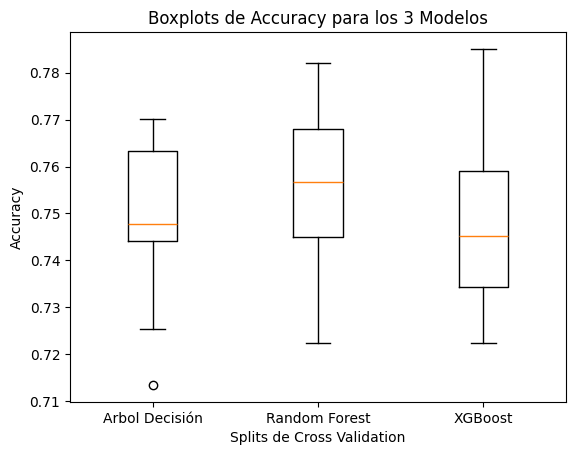

In [52]:
plt.boxplot([ac_1_tree.values,ac_1_RF.values,ac_2_XGB.values], labels = ['Arbol Decisión','Random Forest','XGBoost'])
plt.title('Boxplots de Accuracy para los 3 Modelos')
plt.xlabel('Splits de Cross Validation')
plt.ylabel('Accuracy')
plt.show()

Del box plot el Random Forest sería la mejor elección. Tiene la mediana de accuracy más alta, un rango intercuartílico compacto y muestra buena estabilidad entre los diferentes splits de validación cruzada. Aunque XGBoost tiene un valor máximo similar, su mediana es más baja y tiene mayor variabilidad. El Árbol de Decisión muestra un outlier lo que indica menor robustez. Random Forest ofrece el mejor equilibrio entre accuracy y estabilidad.

### Matriz de Confusión

Generemos una matriz de confusión que permite ver como predice nuestro modelo y que esto nos ayude a tomar una decisión.

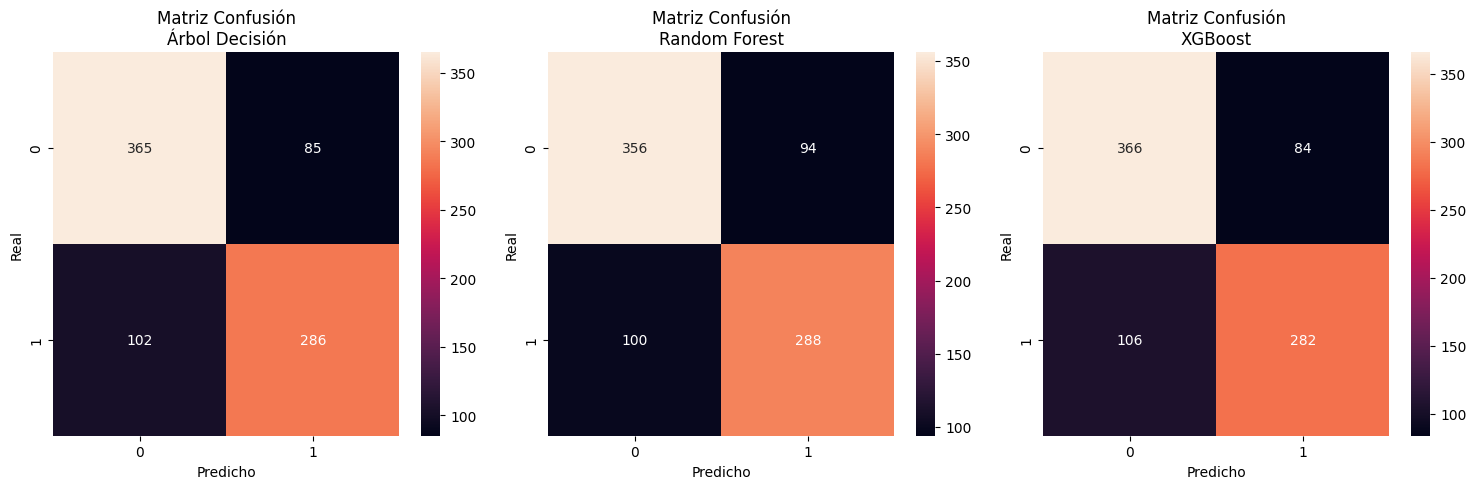

In [53]:
# Obtener predicciones de cada modelo
y_pred_dt = best_model_tree.predict(X_test)
y_pred_rf = best_model_RF.predict(X_test)
y_pred_xgb = best_model_XGB.predict(X_test)

# Crear subplots para las matrices de confusión
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Matriz de confusión para Árbol de Decisión
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', ax=ax1)
ax1.set_title('Matriz Confusión\nÁrbol Decisión')
ax1.set_xlabel('Predicho')
ax1.set_ylabel('Real')

# Matriz de confusión para Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', ax=ax2)
ax2.set_title('Matriz Confusión\nRandom Forest')
ax2.set_xlabel('Predicho')
ax2.set_ylabel('Real')

# Matriz de confusión para XGBoost
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', ax=ax3)
ax3.set_title('Matriz Confusión\nXGBoost')
ax3.set_xlabel('Predicho')
ax3.set_ylabel('Real')

plt.tight_layout()
plt.show()

Aqui podemos ver que para el accuracy (correctamente clasificados/total), XGBoost parece ligeramente superior con 648 predicciones correctas (366+282) de 838 totales. Sin embargo, las diferencias son mínimas entre los tres modelos.

### Curva ROC

Ahora graficamos la curva ROC para ver como se comportan los modelos.

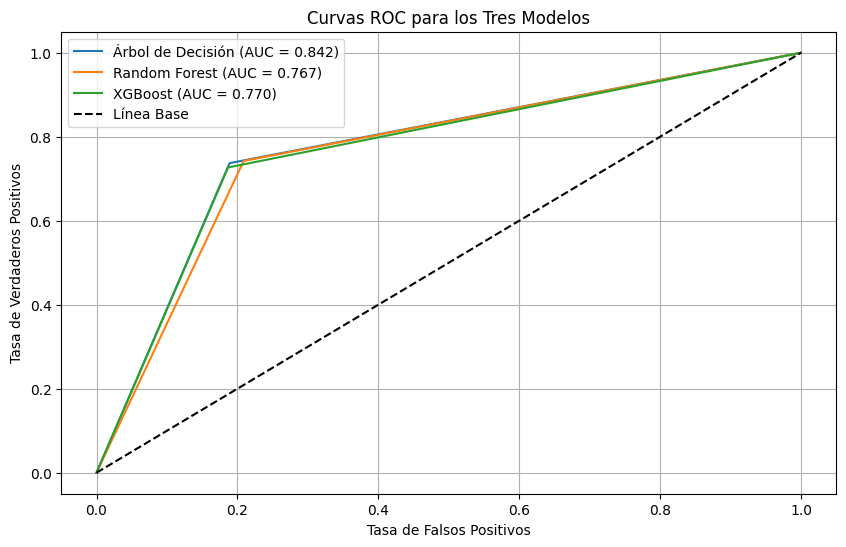

In [56]:
plt.figure(figsize=(10, 6))

# Calcular AUC para cada modelo
auc_dt = roc_auc_score(y_test, y_pred_dt)
auc_rf = roc_auc_score(y_test, y_pred_rf)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

# Graficar las curvas ROC
plt.plot(fpr_dt, tpr_dt, label=f'Árbol de Decisión (AUC = {auc_dt:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Línea Base')

plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC para los Tres Modelos')
plt.legend()
plt.grid(True)


# Obtener predicciones de cada modelo
y_pred_dt = best_model_tree.predict_proba(X_test)[:, 1]


Basado en la curva ROC, el Árbol de Decisión es claramente el mejor modelo con un área bajo la curva de 0.842, significativamente superior a los otros dos. Random Forest (AUC = 0.767) y XGBoost (AUC = 0.770) tienen rendimientos muy similares entre sí, pero considerablemente inferiores al Árbol de Decisión. La curva del Árbol de Decisión está más alejada de la línea base diagonal y más cercana a la esquina superior izquierda, lo que indica mejor capacidad para distinguir entre las clases.

### Sobreajuste

Vamos a ver como se comportan los modelos en entrenamiento vs test, pues nos interesa un modelo que no este sobreajustado.

In [57]:
# Árbol de Decisión
y_train_pred_dt = best_model_tree.predict(X_train)
y_test_pred_dt = best_model_tree.predict(X_test)
acc_train_dt = accuracy_score(y_train, y_train_pred_dt)
acc_test_dt = accuracy_score(y_test, y_test_pred_dt)
diff_dt = acc_train_dt - acc_test_dt
print("\nÁrbol de Decisión:")
print(f"Accuracy en train: {acc_train_dt:.4f}")
print(f"Accuracy en test: {acc_test_dt:.4f}")
print(f"Diferencia (train-test): {diff_dt:.4f}")

# Random Forest
y_train_pred_rf = best_model_RF.predict(X_train)
y_test_pred_rf = best_model_RF.predict(X_test)
acc_train_rf = accuracy_score(y_train, y_train_pred_rf)
acc_test_rf = accuracy_score(y_test, y_test_pred_rf)
diff_rf = acc_train_rf - acc_test_rf
print("\nRandom Forest:")
print(f"Accuracy en train: {acc_train_rf:.4f}")
print(f"Accuracy en test: {acc_test_rf:.4f}")
print(f"Diferencia (train-test): {diff_rf:.4f}")

# XGBoost
y_train_pred_xgb = best_model_XGB.predict(X_train)
y_test_pred_xgb = best_model_XGB.predict(X_test)
acc_train_xgb = accuracy_score(y_train, y_train_pred_xgb)
acc_test_xgb = accuracy_score(y_test, y_test_pred_xgb)
diff_xgb = acc_train_xgb - acc_test_xgb
print("\nXGBoost:")
print(f"Accuracy en train: {acc_train_xgb:.4f}")
print(f"Accuracy en test: {acc_test_xgb:.4f}")
print(f"Diferencia (train-test): {diff_xgb:.4f}")


Árbol de Decisión:
Accuracy en train: 0.8180
Accuracy en test: 0.7768
Diferencia (train-test): 0.0411

Random Forest:
Accuracy en train: 0.8066
Accuracy en test: 0.7685
Diferencia (train-test): 0.0381

XGBoost:
Accuracy en train: 0.8039
Accuracy en test: 0.7733
Diferencia (train-test): 0.0307


Si quiero un modelo que no esté sobreajustado, XGBoost sería la mejor opción. Tiene la menor diferencia entre accuracy de entrenamiento y prueba (0.0307), lo que indica mejor generalización. Random Forest tiene una diferencia intermedia (0.0381) y Árbol de Decisión muestra la mayor diferencia (0.0411), sugiriendo mayor tendencia al sobreajuste. Aunque XGBoost tiene ligeramente menor accuracy en test (0.7733) que Árbol de Decisión (0.7768), su mejor capacidad para generalizar lo hace más confiable para datos nuevos.

## Conclusión: Mejor Modelo

Basándome en todos los análisis previos, elegiré el **XGBoost** como el mejor modelo por lo siguiente:  

**Sobreajuste**: muestra la menor diferencia entre accuracy de train y test (0.0307), lo que indica mejor generalización frente a Random Forest (0.0381) y Árbol de Decisión (0.0411).  
**Accuracy**: XGBoost tiene una accuracy en test de 0.7733, muy cercana a la del Árbol de Decisión (0.7768) y superior a Random Forest (0.7685).  
**Robustez**: Aunque en el boxplot Random Forest mostraba buena estabilidad, XGBoost mantenía un rango aceptable de variabilidad.  
**Matriz de confusión**: XGBoost mostró el mayor número de verdaderos positivos para clase 0 (366).  
**Curva ROC***: Si bien el Árbol de Decisión tiene el mejor AUC (0.842), este alto rendimiento junto con la mayor diferencia train-test sugiere que podría estar sobreajustado.  

El XGBoost ofrece el mejor balance entre buen rendimiento predictivo y baja tendencia al sobreajuste, lo que lo hace más confiable para datos nuevos.